In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import joblib
import dill
from numpy import nan
import random

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

In [3]:
from geo_request import get_coords

# Data loading
---

In [4]:
df_sess = pd.read_csv(
    'data/ga_sessions.csv', 
    dtype={'session_id': str, 'client_id': str}
)
df_sess

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,390x844,Safari,Russia,Stavropol
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk


In [5]:
# из ga_hits загрузим только необходимые столбцы
df_hits = pd.read_csv(
    'data/ga_hits-002.csv',
    usecols=['session_id', 'event_action'],
    dtype={'session_id': str},
)
df_hits

,session_id,event_action
0,5639623078712724064.1640254056.1640254056,quiz_show
1,7750352294969115059.1640271109.1640271109,quiz_show
2,885342191847998240.1640235807.1640235807,quiz_show
3,142526202120934167.1640211014.1640211014,quiz_show
4,3450086108837475701.1640265078.1640265078,quiz_show
...,...,...
15726465,6866159858916559617.1640270865.1640270865,quiz_show
15726466,7310304587364460692.1640261783.1640261783,quiz_show
15726467,8013702685784312179.1640270195.1640270195,quiz_show
15726468,8021505554734405918.1640257821.1640257821,quiz_show


# Data cleaning
---

## Drop useless data

In [6]:
# проверим, есть ли для всех сессий в ga_sessions сооттвтетствующие записи в ga_hits
df_sess.session_id.isin(df_hits.session_id).all()

False

In [7]:
# и наоборот
df_hits.session_id.isin(df_sess.session_id).all()

False

In [8]:
# удалим из датасета hits записи, у которых нет соответствия
df_hits = df_hits.query("session_id.isin(@df_sess.session_id)")
df_hits.shape

(15685219, 2)

In [9]:
df_hits.session_id.isin(df_sess.session_id).all()

True

In [10]:
# записи в df_sessions, для которых нет данных в ga_hits, сохраним отдельно,
# будем использовать их для тестирования api
df_for_test = df_sess.query("~session_id.isin(@df_hits.session_id)")
df_for_test.shape

(127776, 18)

In [11]:
df = df_sess.drop(df_for_test.index)
df.shape

(1732266, 18)

In [12]:
df.session_id.isin(df_hits.session_id).all()

True

In [13]:
# оставим в тестовом датасете только полностью заполненные записи
df_for_test = df_for_test.dropna()
df_for_test.shape

(1111, 18)

In [14]:
# сохранение в json
df_for_test.to_json('data/data_for_test.json', orient='records')

## Drop duplicates

In [15]:
df.shape

(1732266, 18)

In [16]:
# проверка на дубликаты
df.drop_duplicates().shape

(1732266, 18)

In [17]:
# дубликатов нет
df_init = df.copy()

## Imputation

In [18]:
df = df_init.copy()
df.shape

(1732266, 18)

In [19]:
def count_na(df: pd.DataFrame, zero_vals: bool=False) -> None:
    """Counts NaN values for each column"""
    na_rows = df[df.isna().any(axis=1)]
    na_counts = na_rows.count().apply(lambda x: len(na_rows) - x)
    
    print('Количество незаполненных значений по столбцам:')
    
    if zero_vals:
        print(na_counts.sort_values(ascending=False))
    else:
        print(na_counts[na_counts != 0].sort_values(ascending=False))

In [20]:
count_na(df)

Количество незаполненных значений по столбцам:
device_model     1717204
utm_keyword      1020752
device_os        1013964
device_brand      347196
utm_adcontent     304137
utm_campaign      195287
utm_source            76
dtype: int64


In [21]:
# количество пропусков в device_model более 98%, поэтому удалим её полностью
df.drop(columns=['device_model'], inplace=True)

### functions for filling NaNs

In [22]:
df.device_category.value_counts()

mobile     1368679
desktop     346891
tablet       16696
Name: device_category, dtype: int64

In [23]:
def device_value_counts(data: pd.DataFrame, column: str) -> None:
    """print top values for each device category"""
    print(f"{column} top values:\n---------------------------------")
    for cat in ['mobile', 'desktop', 'tablet']:
        print(f"{cat}:")
        print(data.groupby(by='device_category')[column].value_counts(dropna=False)[cat]. \
              head().to_string(header=False))
        print()

предполагаем, что распределение значений для фич utm_* и device_* зависят от категории устройства (device_category)

In [24]:
# проверим для utm_campaign
device_value_counts(df, column='utm_campaign')

utm_campaign top values:
---------------------------------
mobile:
LEoPHuyFvzoNfnzGgfcd    318873
LTuZkdKfxRGVceoWkVyg    283561
FTjNLDyTrXaWYgZymFkV    172115
NaN                     134039
gecBYcKZCPMcVYdSSzKP    132181

desktop:
LTuZkdKfxRGVceoWkVyg    135249
FTjNLDyTrXaWYgZymFkV     61359
NaN                      58399
okTXSMadDkjvntEHzIjp     10126
YCKgTzTDywjcWyQudGch      8670

tablet:
LTuZkdKfxRGVceoWkVyg    4182
NaN                     2849
LEoPHuyFvzoNfnzGgfcd    1847
FTjNLDyTrXaWYgZymFkV    1476
gecBYcKZCPMcVYdSSzKP     802



In [25]:
# функции для построения barplot:
def campaign_count():
    df_camp = pd.DataFrame()
    for cat in ('mobile', 'desktop', 'tablet'):
        df_temp = pd.DataFrame()
        df_temp[['utm_campaign', 'count']] = df[df.device_category == cat]['utm_campaign'].value_counts(dropna=False)[:10].reset_index()
        total_amt = df_temp['count'].sum()
        df_temp['perc'] = df_temp['count'].div(total_amt).mul(100)
        df_temp['device_category'] = cat
        df_camp = pd.concat([df_camp, df_temp.dropna()], ignore_index=True)
    return df_camp
        
df_camp = campaign_count()

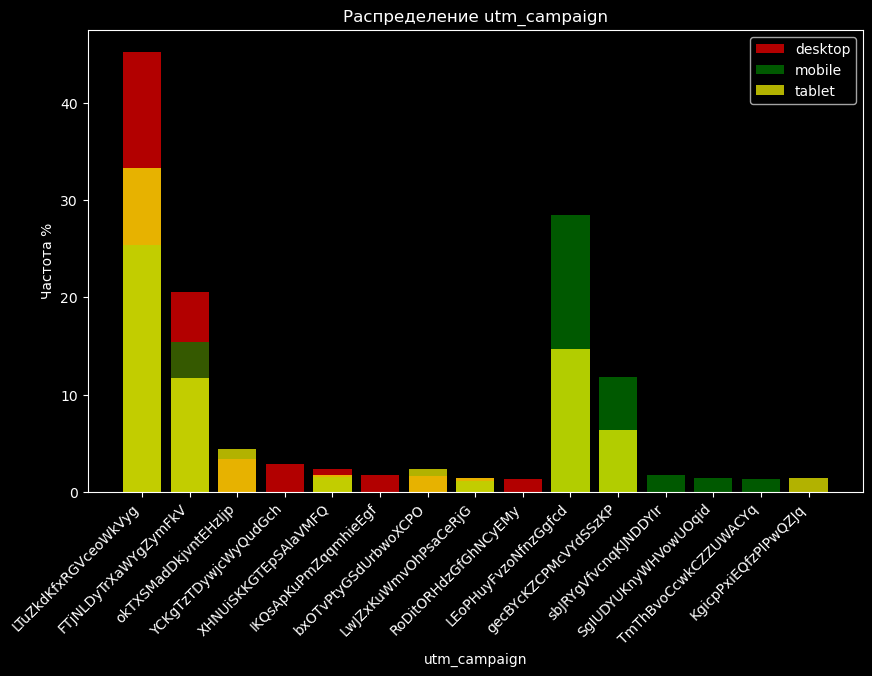

In [26]:
def campaign_plot():
    colors = ('red', 'green', 'yellow')
    os = ('desktop', 'mobile', 'tablet')

    plt.style.use('dark_background')
    plt.figure(figsize=(10, 6))

    for dev_cat, col in zip(os, colors):
        plt.bar(df_camp[df_camp.device_category == dev_cat]['utm_campaign'],
                df_camp[df_camp.device_category == dev_cat]['perc'],
                color=col, alpha=0.7)
    plt.xticks(rotation=45, horizontalalignment='right')
    # plt.yscale('log')
    plt.xlabel('utm_campaign')
    plt.ylabel('Частота %')
    plt.legend(labels=os)
    plt.title('Распределение utm_campaign')
    return plt

campaign_plot().show();

In [27]:
# и для device_os
device_value_counts(df, column='device_os')

device_os top values:
---------------------------------
mobile:
NaN           766296
Android       421358
iOS           180907
Linux             47
BlackBerry        24

desktop:
NaN          236790
Windows       81724
Macintosh     23395
Linux          4562
(not set)       302

tablet:
NaN          10878
Android       4142
iOS           1659
Macintosh       10
Linux            7



In [28]:
# функции для построения barplot:
def os_count():
    df_os = pd.DataFrame()
    for cat in ('mobile', 'desktop', 'tablet'):
        df_temp = pd.DataFrame()
        df_temp[['device_os', 'count']] = df[df.device_category == cat]['device_os'].value_counts(dropna=False).reset_index()
        total_amt = df_temp['count'].sum()
        df_temp['perc'] = df_temp['count'].div(total_amt).mul(100)
        df_temp['device_category'] = cat
        df_os = pd.concat([df_os, df_temp.dropna()], ignore_index=True)
    return df_os
        
df_os = os_count()

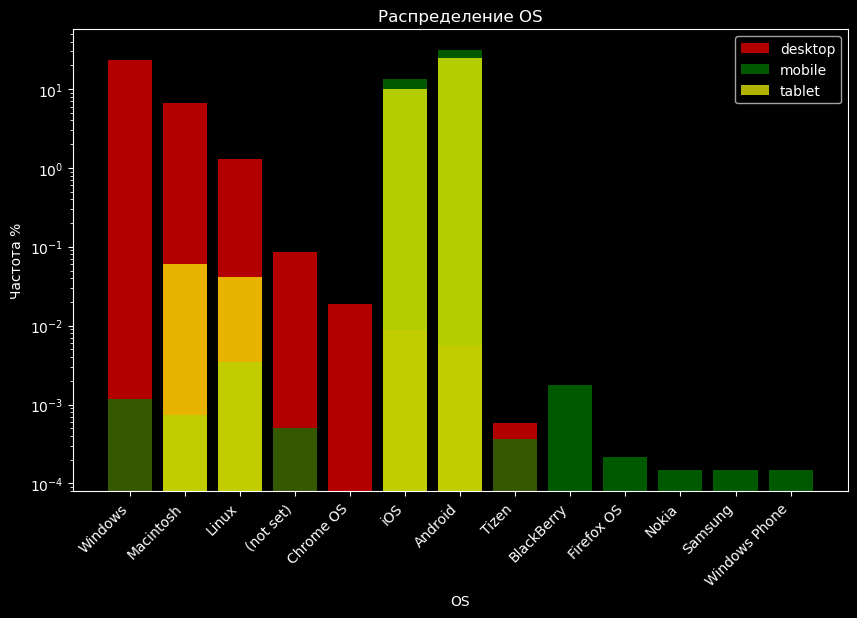

In [29]:
def os_plot():
    colors = ('red', 'green', 'yellow')
    os = ('desktop', 'mobile', 'tablet')

    plt.style.use('dark_background')
    plt.figure(figsize=(10, 6))

    for dev_cat, col in zip(os, colors):
        plt.bar(df_os[df_os.device_category == dev_cat]['device_os'],
                df_os[df_os.device_category == dev_cat]['perc'],
                color=col, alpha=0.7)
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.yscale('log')
    plt.xlabel('OS')
    plt.ylabel('Частота %')
    plt.legend(labels=os)
    plt.title('Распределение OS')
    return plt

os_plot().show();

как видно, распределение значений для рассмотренных фич сильно зависят от категории устройства (device_category)

определим функцию, которая заполняет пропуски в категориальных фичах, 
основываясь на частоте распределения значений отдельно для каждой категории устройства (device_category)

In [32]:
random.seed(42)

def random_value(freq: dict) -> str:
    """returns random key from freq dict, according weights in dict values"""    
    val = list(freq.keys())
    weights = list(freq.values())
    while True:
        yield random.choices(
            val,
            weights = weights
        )[0]

In [33]:
def fillna_devicecat(data: pd.DataFrame, column: str):
    """fill NaNs in selected column with random values, according distibution frequencies for each device category"""  
    
    dev_category = ('mobile', 'desktop', 'tablet')
    
    for dev_cat in dev_category:
        df_cat = data.query("device_category == @dev_cat").copy()
        column_freq = df_cat[column].value_counts().to_dict()
        gen_col = random_value(column_freq)
        df_cat[column] = df_cat[column].apply(lambda x: next(gen_col) if x is nan else x)
        data.loc[df_cat.index, :] = df_cat
        
    return data

### keyword

In [34]:
df.utm_keyword.value_counts(dropna=False)

NaN                     1020752
puhZPIYqKXeFPaUviSjo     465950
aXQzDWsJuGXeBXexNHjc      18154
ITfrGJNwVsHBGJMAKoct      12395
pHqgLcdBQPSLcrTpLkdr      12320
                         ...   
VBmazutCflYumtDHrQYe          1
jWQZKvbKuDnnQLCqeuOF          1
WFIDyezrAGnnopAqVVDs          1
NLWjXuYiXlKrFJfSWfKt          1
fcXWTQaKfxbkBkBnzLhK          1
Name: utm_keyword, Length: 1193, dtype: int64

In [35]:
# заполним пропуски в завсимости от распределения keyword в каждой категории устройства
df2 = fillna_devicecat(df, column='utm_keyword')

In [36]:
df2.utm_keyword.value_counts(dropna=False)

puhZPIYqKXeFPaUviSjo    1109138
aXQzDWsJuGXeBXexNHjc      50697
ITfrGJNwVsHBGJMAKoct      33008
pHqgLcdBQPSLcrTpLkdr      28608
UKNBOHebRIIsQRsjNKay      28381
                         ...   
iNaIAFVuZgYukekFQQbX          1
vDQgBOvEhnoqevZDGOUT          1
zFUXnxOPohSdmGrQzhoq          1
SoCnOWJkUDarGowlGDnC          1
fcXWTQaKfxbkBkBnzLhK          1
Name: utm_keyword, Length: 1192, dtype: int64

### OS

In [37]:
df2.device_os.value_counts(dropna=False)

NaN              1013964
Android           425520
iOS               182597
Windows            81740
Macintosh          23415
Linux               4616
(not set)            309
Chrome OS             65
BlackBerry            24
Tizen                  7
Firefox OS             3
Nokia                  2
Samsung                2
Windows Phone          2
Name: device_os, dtype: int64

In [38]:
# заполним пропуски в завсимости от распределения os в каждой категории устройства
df3 = fillna_devicecat(df2, 'device_os')

In [39]:
df3.groupby(by='device_category').device_os.value_counts(dropna=False)

device_category  device_os    
desktop          Windows          257353
                 Macintosh         73691
                 Linux             14516
                 (not set)           967
                 Chrome OS           204
                 iOS                  97
                 Android              60
                 Tizen                 3
mobile           Android          956953
                 iOS              411472
                 Linux               105
                 BlackBerry           53
                 Windows              33
                 Macintosh            19
                 Tizen                14
                 (not set)            12
                 Firefox OS           10
                 Samsung               3
                 Windows Phone         3
                 Nokia                 2
tablet           Android           11928
                 iOS                4713
                 Linux                28
                 Macintosh

### Device brand

In [40]:
device_value_counts(df3, 'device_brand')

device_brand top values:
---------------------------------
mobile:
Apple      497680
Samsung    307088
Xiaomi     269016
Huawei     170591
Realme      17917

desktop:
NaN          346752
Apple            70
Huawei           19
(not set)        10
Xiaomi           10

tablet:
Apple      5783
Samsung    4545
Huawei     3218
Lenovo     1560
Google      362



In [41]:
desktop = df3.query("device_category == 'desktop'").copy()
desktop.device_brand.value_counts(dropna=False).head()

NaN          346752
Apple            70
Huawei           19
Xiaomi           10
(not set)        10
Name: device_brand, dtype: int64

In [42]:
# про производителя устройст категории desktop почти ничего не изветсно,
# скинем все пропуски в (not_set)
desktop.device_brand.fillna('(not set)', inplace=True)
df4 = df3.copy()
df4.loc[desktop.index, :] = desktop

In [43]:
df4.query("device_category == 'desktop'").device_brand.value_counts(dropna=False).head()

(not set)    346762
Apple            70
Huawei           19
Xiaomi           10
Samsung           8
Name: device_brand, dtype: int64

In [44]:
# остальное заполними в соответствии с распределенями
df4 = fillna_devicecat(df4, 'device_brand')

In [45]:
df4.query("device_brand.isna()").shape

(0, 17)

### campaign

In [46]:
df4.utm_campaign.value_counts(dropna=False).head()

LTuZkdKfxRGVceoWkVyg    422992
LEoPHuyFvzoNfnzGgfcd    321286
FTjNLDyTrXaWYgZymFkV    234950
NaN                     195287
gecBYcKZCPMcVYdSSzKP    133247
Name: utm_campaign, dtype: int64

In [47]:
# заполним пропуски в завсимости от распределения campaign в каждой категории устройства
df5 = fillna_devicecat(df4, 'utm_campaign')

In [48]:
df5.utm_campaign.value_counts(dropna=False).head()

LTuZkdKfxRGVceoWkVyg    481929
LEoPHuyFvzoNfnzGgfcd    356270
FTjNLDyTrXaWYgZymFkV    266512
gecBYcKZCPMcVYdSSzKP    147925
XHNUiSKKGTEpSAlaVMFQ     27006
Name: utm_campaign, dtype: int64

In [49]:
df5.query("utm_campaign.isna()").shape

(0, 17)

### Adcontent

In [50]:
df5.utm_adcontent.value_counts(dropna=False).head()

JNHcPlZPxEMWDnRiyoBf    935408
NaN                     304137
vCIpmpaGBnIQhyYNkXqp    179438
xhoenQgDQsgfEPYNPwKO    104381
PkybGvWbaqORmxjNunqZ     59038
Name: utm_adcontent, dtype: int64

In [51]:
print(df5.groupby(by='utm_campaign').utm_adcontent.value_counts().to_string()[:1000])

utm_campaign          utm_adcontent       
AdtHYglxfCpTpwZeTAuW  JNHcPlZPxEMWDnRiyoBf         1
AqudXfUnmXWSDWVGYaXr  JNHcPlZPxEMWDnRiyoBf        20
                      XKsYZiUFcdkUXQpoLKyS         2
                      aYAcKhelKzYpXrRYknSP         2
                      vIKILzdGQEEbEpgPefxF         2
BAZCuyHZnaPrMGOMrcCQ  JNHcPlZPxEMWDnRiyoBf       470
                      XKsYZiUFcdkUXQpoLKyS         1
BHcvLfOaCWvWTykYqHVe  eCPVFTOzrcBYtbtWCUpF        20
                      jMNfDMEvJFVnXWOpECtJ        10
                      JNHcPlZPxEMWDnRiyoBf         1
BKeImrJuRDZcHiSSTdzm  ODLcVlzKCdodjHQNkIoL        38
                      guyNoEvzgofQvvwExGOq        24
                      UkMhhhbZmYgIctIeIFcd        17
                      JJRVNKFvKSInZxhrcjHK        12
                      GVUsmTlgLwSaIkbKDGtP         6
                      rcPTSYUkeyIdANHAzyqt         5
                      JNHcPlZPxEMWDnRiyoBf         1
                      QMmfrhgnqNOwSTPaqlLK         1
BTR

видим, что для каждогой кампании есть свой набор utm_adcontent

In [52]:
# создадим словарь с парами кампания - самый популярный adcontent
campaigns = dict()
for camp in df5.utm_campaign.unique():
    ad_count = df5[df5.utm_campaign == camp].utm_adcontent.value_counts()
    if len(ad_count) != 0:
        campaigns[camp] = ad_count.idxmax()
    else:
        campaigns[camp] = nan

In [53]:
{k: v for k, v in list(campaigns.items())[70:80]}

{'yCnTwlCLkqZHwAglrEll': 'OJiWyBKOyDITzXCZRSMH',
 'FrZxVhBshHjYZTtbPhxK': 'JNHcPlZPxEMWDnRiyoBf',
 'jvsVVQVKRfBIqBDBuCkq': 'JNHcPlZPxEMWDnRiyoBf',
 'HEimDfYZIzuQXDZAAcEW': 'XSkXBCPfnJjvxbfeewtd',
 'lDZWtjMawBaqetnVFboy': nan,
 'DnEUulZAecfGPvdtZBYS': 'JNHcPlZPxEMWDnRiyoBf',
 'qTERPbkOaRvjtQXXEwdb': 'JNHcPlZPxEMWDnRiyoBf',
 'WZxCpdfLzrgIfGUqxGpE': 'JNHcPlZPxEMWDnRiyoBf',
 'ZWwGecvpGmryAHpoosvq': nan,
 'QejVLgNgzFMqjZPsnfxa': 'JNHcPlZPxEMWDnRiyoBf'}

In [54]:
# заполняем пропуски в adcontent, которые можно заполнить, 
# самыми популярными значениями из campaign
nan_ad = df5[df5.utm_adcontent.isna() & ~df5.utm_campaign.isna()].copy()
nan_ad['utm_adcontent'] = nan_ad.utm_campaign.apply(lambda x: campaigns[x])

In [55]:
nan_ad.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow
14,9055469620715506713.1636559415.1636559415,2108390820.1628883993,2021-11-10,18:50:15,4,SzZERoLMmrEUEhDaYcyN,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,412x869,Android Webview,Russia,Saint Petersburg
27,9055504865227535872.1639282176.1639282176,2108399026.1639282176,2021-12-12,07:09:36,1,BHcvLfOaCWvWTykYqHVe,cpc,sbJRYgVfvcnqKJNDDYIr,JNHcPlZPxEMWDnRiyoBf,okTXSMadDkjvntEHzIjp,mobile,Android,Samsung,385x854,Chrome,Russia,Moscow
37,905553874150070422.1639028885.1639028885,210840691.1639028886,2021-12-09,08:48:05,1,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,cdPAGAvKeBGoqAkQBuGR,mobile,iOS,Apple,375x812,Safari,Russia,Moscow
39,905553874150070422.1639041598.1639041598,210840691.1639028886,2021-12-09,12:19:58,4,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,cdPAGAvKeBGoqAkQBuGR,mobile,iOS,Apple,375x812,Safari,Russia,Moscow


In [56]:
df6 = df5.copy()

In [57]:
df6.loc[nan_ad.index, :] = nan_ad

In [58]:
df6.loc[nan_ad.index, :].head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow
14,9055469620715506713.1636559415.1636559415,2108390820.1628883993,2021-11-10,18:50:15,4,SzZERoLMmrEUEhDaYcyN,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,412x869,Android Webview,Russia,Saint Petersburg
27,9055504865227535872.1639282176.1639282176,2108399026.1639282176,2021-12-12,07:09:36,1,BHcvLfOaCWvWTykYqHVe,cpc,sbJRYgVfvcnqKJNDDYIr,JNHcPlZPxEMWDnRiyoBf,okTXSMadDkjvntEHzIjp,mobile,Android,Samsung,385x854,Chrome,Russia,Moscow
37,905553874150070422.1639028885.1639028885,210840691.1639028886,2021-12-09,08:48:05,1,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,cdPAGAvKeBGoqAkQBuGR,mobile,iOS,Apple,375x812,Safari,Russia,Moscow
39,905553874150070422.1639041598.1639041598,210840691.1639028886,2021-12-09,12:19:58,4,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,cdPAGAvKeBGoqAkQBuGR,mobile,iOS,Apple,375x812,Safari,Russia,Moscow


In [59]:
count_na(df6)

Количество незаполненных значений по столбцам:
utm_adcontent    3909
utm_source         76
dtype: int64


In [60]:
# оставшиеся пропуски в adcontent заполним в соответствии с распределением по категории девайса
df6 = fillna_devicecat(df6, 'utm_adcontent')

### Source

In [61]:
df7 = fillna_devicecat(df6, 'utm_source')

In [62]:
count_na(df7)

Количество незаполненных значений по столбцам:
Series([], dtype: int64)


In [63]:
df_imp = df7.copy()

In [64]:
df_imp.shape

(1732266, 17)

## Types

In [65]:
df = df_imp.copy()

In [66]:
df.dtypes

session_id                  object
client_id                   object
visit_date                  object
visit_time                  object
visit_number                 int64
utm_source                  object
utm_medium                  object
utm_campaign                object
utm_adcontent               object
utm_keyword                 object
device_category             object
device_os                   object
device_brand                object
device_screen_resolution    object
device_browser              object
geo_country                 object
geo_city                    object
dtype: object

### Parse Datetime

In [67]:
# переведём два столбца с датой и временем в один типа datetime
df['visit_dt'] = pd.to_datetime(df['visit_date'] + ' ' + df['visit_time'])

In [68]:
df['visit_dt']

0         2021-11-24 14:36:32
1         2021-11-14 08:21:30
2         2021-12-28 02:42:06
3         2021-05-29 05:00:00
4         2021-05-29 05:00:00
                  ...        
1860037   2021-12-22 10:48:25
1860038   2021-05-26 08:00:00
1860039   2021-11-15 15:31:55
1860040   2021-11-29 15:36:44
1860041   2021-12-31 19:39:02
Name: visit_dt, Length: 1732266, dtype: datetime64[ns]

In [69]:
df.drop(columns=['visit_date', 'visit_time'], inplace=True)
df.shape

(1732266, 16)

In [70]:
df.dtypes

session_id                          object
client_id                           object
visit_number                         int64
utm_source                          object
utm_medium                          object
utm_campaign                        object
utm_adcontent                       object
utm_keyword                         object
device_category                     object
device_os                           object
device_brand                        object
device_screen_resolution            object
device_browser                      object
geo_country                         object
geo_city                            object
visit_dt                    datetime64[ns]
dtype: object

## Аномалии и выбросы

In [71]:
def quantile_bondaries(data: pd.Series) -> tuple[float]:
    """Определение границ интерквартильного размаха"""
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    return q25 - 1.5 * iqr, q75 + 1.5 * iqr

In [72]:
def sigma_bondaries(data: pd.Series) -> tuple[float]:
    low = data.mean() - 3 * data.std()
    hi = data.mean() + 3 * data.std()    
    return low, hi

#### visit_number

In [73]:
df.visit_number.describe().apply(lambda x: f"{x :.2f}")

count    1732266.00
mean           2.63
std           11.64
min            1.00
25%            1.00
50%            1.00
75%            1.00
max          564.00
Name: visit_number, dtype: object

In [74]:
visit_bond = sigma_bondaries(df.visit_number)
visit_bond

(-32.29996379427241, 37.55563353552461)

выбросы заменим значением верхней границы

In [76]:
df.visit_number.mask(df.visit_number > visit_bond[1], int(visit_bond[1]), inplace=True)

In [77]:
df.visit_number.describe().apply(lambda x: f"{x :.2f}")

count    1732266.00
mean           2.09
std            4.21
min            1.00
25%            1.00
50%            1.00
75%            1.00
max           37.00
Name: visit_number, dtype: object

In [78]:
df.shape

(1732266, 16)

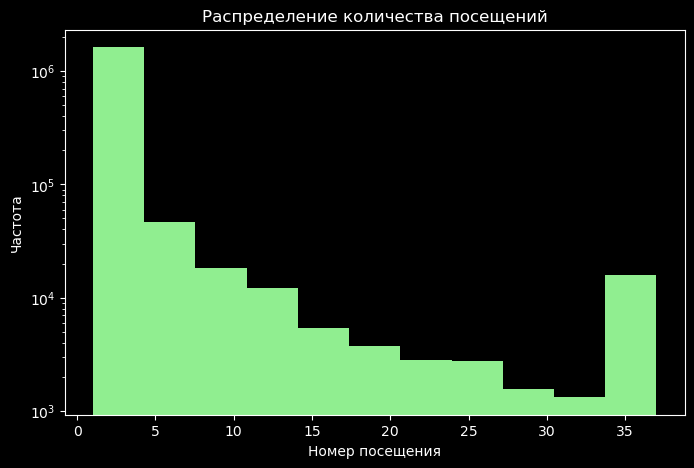

In [79]:
plt.style.use('dark_background')
plt.figure(figsize=(8, 5))
plt.hist(df.visit_number, bins=11, color='lightgreen')
plt.xlabel('Номер посещения')
plt.ylabel('Частота')
plt.yscale('log')
plt.title('Распределение количества посещений');

In [80]:
df_out = df.copy()

# Feature engineering
---

In [81]:
df = df_out.copy()

In [82]:
df.shape

(1732266, 16)

## "target_action" feature

In [83]:
# добавим target action - результат действий на сайте из ga_hits
target_actions = ('sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click',
                  'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click', 
                  'sub_submit_success', 'sub_car_request_submit_click')

In [84]:
df_hits2 = df_hits.query("event_action.isin(@target_actions)")
df_hits2

,session_id,event_action
4016,2744563715298057088.1640258436.1640258436,sub_submit_success
4045,3087297479839089634.1640268774.1640268774,sub_submit_success
4046,3156966333326004302.1640206419.1640206800,sub_submit_success
4047,3750243879753098158.1640272208.1640272208,sub_submit_success
4048,7518333712042258254.1640258901.1640258901,sub_submit_success
...,...,...
15725025,1277864870843199549.1636773954.1636773954,sub_car_claim_submit_click
15725133,965861352491898977.1636751459.1636751459,sub_submit_success
15725134,4727705172767122620.1636818847.1636818847,sub_submit_success
15725135,4727705172767122620.1636818847.1636818847,sub_open_dialog_click


In [85]:
# все сессии, которые привели к target action
id_set = set(df_hits2.session_id.values)

In [86]:
# добавим 1, если произошло целевое действие, иначе 0
df['target_action'] = df.session_id.apply(
    lambda id_:
    1 if id_ in id_set
    else 0
)

In [87]:
df.target_action.value_counts()

0    1681952
1      50314
Name: target_action, dtype: int64

In [88]:
df

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,visit_dt,target_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,2021-11-24 14:36:32,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,2021-11-14 08:21:30,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,2021-12-28 02:42:06,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,UvuMsOSDBWQGOIbDbXfV,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,2021-05-29 05:00:00,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,2021-05-29 05:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,1,BHcvLfOaCWvWTykYqHVe,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,VlqBmecIOXWjCWUmQkLd,desktop,Windows,(not set),1920x1080,Chrome,Russia,Moscow,2021-12-22 10:48:25,0
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,tVtbIKrPSOvrXLCznVVe,mobile,Android,Apple,390x844,Safari,Russia,Stavropol,2021-05-26 08:00:00,0
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,375x667,Safari,Russia,Moscow,2021-11-15 15:31:55,0
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,2021-11-29 15:36:44,0


In [89]:
df2 = df.copy()

## day of week & daytime

In [97]:
# добавим фичу День недели
df2['dayofweek'] = df2.visit_dt.dt.day_name()

In [98]:
def get_daytime(dt) -> str:
    if 0 <= dt.hour < 6: return 'night'
    elif 6 <= dt.hour < 12: return 'morning'
    elif 12 <= dt.hour < 18: return 'afternoon'
    elif 18 <= dt.hour: return 'evening'

In [99]:
# добавим фичу Время суток
df2['daytime'] = df2.visit_dt.apply(get_daytime)

In [100]:
df2.head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,visit_dt,target_action,dayofweek,daytime
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,2021-11-24 14:36:32,0,Wednesday,afternoon
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,2021-11-14 08:21:30,0,Sunday,morning
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,2021-12-28 02:42:06,0,Tuesday,night
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,UvuMsOSDBWQGOIbDbXfV,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,2021-05-29 05:00:00,0,Saturday,night
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,2021-05-29 05:00:00,0,Saturday,night


## pixels

In [101]:
df2.device_screen_resolution.describe()

count     1732266
unique       4947
top       414x896
freq       155140
Name: device_screen_resolution, dtype: object

In [102]:
df3 = df2.copy()

In [103]:
# добавим фичу pixels, равную десятичному логарифму общего количества пикселей устройства
def get_total_pixels(res: str) -> int:
    pixels = int(int.__mul__(*map(int, res.split('x'))))
    return math.log(pixels, 10) if pixels else 0

In [104]:
df3['pixels'] = df3.device_screen_resolution.apply(get_total_pixels)

In [105]:
df3.pixels.describe().apply(lambda x: f"{x :.3f}")

count    1732266.000
mean           5.634
std            0.310
min            0.000
25%            5.448
50%            5.524
75%            5.576
max            7.505
Name: pixels, dtype: object

In [106]:
# удалим строки со значением pixels 0 и разрешением 0x0, как аномальные
df3.query("pixels == 0").head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,visit_dt,target_action,dayofweek,daytime,pixels
44288,950433344634896286.1638285216.1638285216,221290007.1638285214,1,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,KCcEkEaKEtUilBVMoCAi,desktop,Windows,(not set),0x0,Chrome,Russia,Moscow,2021-11-30 18:13:36,0,Tuesday,evening,0.0
63108,1034855208904127115.1622241934.1622241934,240946004.1622241931,1,kjsLglQLzykiRbcDiGcD,cpc,LTuZkdKfxRGVceoWkVyg,aYAcKhelKzYpXrRYknSP,puhZPIYqKXeFPaUviSjo,desktop,Windows,(not set),0x0,Edge,Russia,Saint Petersburg,2021-05-29 01:00:00,0,Saturday,night,0.0
116630,1275445726215482012.1633495707.1633495707,296962849.1633495708,1,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,iOS,Huawei,0x0,YaBrowser,Russia,Vladivostok,2021-10-06 07:00:00,0,Wednesday,morning,0.0
268575,1959491500856234812.1626264380.1626264380,456229667.1626264380,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,qUcotcWimEOQiboVPcCx,desktop,Windows,(not set),0x0,Chrome,Russia,Saint Petersburg,2021-07-14 15:00:00,0,Wednesday,afternoon,0.0
466768,2840248306670648388.1627536509.1627536509,661296841.1627536452,1,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,0x0,YaBrowser,Russia,Moscow,2021-07-29 08:00:00,0,Thursday,morning,0.0


In [107]:
df3.drop(index=df3.query("pixels == 0").index, inplace=True)

In [108]:
# добавим фичу screen_aspect, показывающую отношение сторон экрана
def get_screen_aspect(res: str) -> float:
    aspect = 1 / int.__truediv__(*map(int, res.split('x')))
    return round(aspect, 1)

In [109]:
df3['screen_aspect'] = df3.device_screen_resolution.apply(get_screen_aspect)

In [110]:
df3.screen_aspect.describe().apply(lambda x: f"{x :.3f}")

count    1732257.000
mean           1.773
std            0.639
min            0.200
25%            1.800
50%            2.200
75%            2.200
max           12.500
Name: screen_aspect, dtype: object

In [111]:
# удалим строки со значением aspect 12.5 и разрешением 1600x20000, как аномальные
df3.query("screen_aspect == 12.5").head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,...,device_screen_resolution,device_browser,geo_country,geo_city,visit_dt,target_action,dayofweek,daytime,pixels,screen_aspect
7690,9089787985673454509.1638794162.1638794162,2116381187.1638794157,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(not set),...,1600x20000,Chrome,(not set),(not set),2021-12-06 15:36:02,0,Monday,afternoon,7.50515,12.5
16893,9130259934944875721.1633604811.1633604811,2125804297.1633604809,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,aXQzDWsJuGXeBXexNHjc,desktop,Windows,...,1600x20000,Chrome,(not set),(not set),2021-10-07 14:00:00,0,Thursday,afternoon,7.50515,12.5
54385,994460654948701315.1632752773.1632752773,231540914.1632752771,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,zXjuoqEaPElBnwpSHMpx,desktop,Macintosh,...,1600x20000,Chrome,(not set),(not set),2021-09-27 17:00:00,0,Monday,afternoon,7.50515,12.5
112711,1257484293244700670.1635502080.1635502080,292780877.1635502078,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(not set),...,1600x20000,Chrome,(not set),(not set),2021-10-29 13:08:00,0,Friday,afternoon,7.50515,12.5
119839,1290093398651180319.1638798624.1638798624,300373276.1638798623,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,(not set),...,1600x20000,Chrome,(not set),(not set),2021-12-06 16:50:24,0,Monday,afternoon,7.50515,12.5


In [112]:
df4 = df3.drop(index=df3.query("screen_aspect == 12.5").index)
df4.shape

(1732229, 21)

In [113]:
df4.screen_aspect.describe().apply(lambda x: f"{x :.3f}")

count    1732229.000
mean           1.772
std            0.637
min            0.200
25%            1.800
50%            2.200
75%            2.200
max            3.000
Name: screen_aspect, dtype: object

## Browser

In [114]:
df4.device_browser.value_counts()

Chrome                              951539
Safari                              436705
YaBrowser                           123763
Safari (in-app)                      65952
Android Webview                      51919
Samsung Internet                     44273
Opera                                25094
Firefox                              15738
Edge                                 15195
UC Browser                             815
Mozilla Compatible Agent               336
Android Runtime                        241
[FBAN                                  115
Instagram 208.0.0.32.135 Android        72
MRCHROME                                72
Instagram 209.0.0.21.119 Android        49
Android Browser                         47
Puffin                                  43
Maxthon                                 30
Internet Explorer                       24
Opera Mini                              23
Android                                 19
Instagram 202.0.0.23.119                17
Mozilla    

In [115]:
# оставим только первое слово от названия браузера
df4['device_browser'] = df4.device_browser.apply(lambda x: x.split()[0])

In [116]:
df4.device_browser.value_counts()

Chrome                      951539
Safari                      502657
YaBrowser                   123763
Android                      52226
Samsung                      44273
Opera                        25117
Firefox                      15738
Edge                         15195
UC                             815
Mozilla                        352
Instagram                      218
[FBAN                          115
MRCHROME                        72
Puffin                          43
Maxthon                         30
Internet                        24
(not                            11
com.vk.vkclient                  8
Coc                              6
helloworld                       6
Amazon                           6
SeaMonkey                        3
MyApp                            2
NetFront                         2
Iron                             2
MT6735_TD                        1
NokiaX2-02                       1
Nokia501                         1
com.zhiliaoapp.music

In [117]:
# оставим только 8 популярных браузеров, остальные заменем на "other"
browsers = tuple(df4.device_browser.value_counts()[:8].index)
print(browsers)

('Chrome', 'Safari', 'YaBrowser', 'Android', 'Samsung', 'Opera', 'Firefox', 'Edge')


In [118]:
df4['device_browser'] = df4.device_browser.apply(
    lambda x: 
    x if x in browsers
    else 'other'
)

In [119]:
df4.device_browser.value_counts(dropna=False)

Chrome       951539
Safari       502657
YaBrowser    123763
Android       52226
Samsung       44273
Opera         25117
Firefox       15738
Edge          15195
other          1721
Name: device_browser, dtype: int64

In [120]:
df5 = df4.copy()

## Geo

In [121]:
# рассмотрим, какое количество целевых действий было совершено из каждой страны
df5.groupby(by='geo_country').target_action.sum().sort_values(ascending=False)

geo_country
Russia           49156
Ukraine            199
Germany             78
United States       64
Belarus             59
                 ...  
Luxembourg           0
Libya                0
Lebanon              0
Burundi              0
Zimbabwe             0
Name: target_action, Length: 159, dtype: int64

подавляющее большинство целевых действий совершалось из России,
кроме того, географическая информация содежится также в категории города,
поэтому удалим эту фичу (на следующем шаге) 

### Distance to Moscow

In [123]:
# добавим фичу "Дистанция до Москвы"
df5.groupby(by='geo_city').target_action.sum().sort_values(ascending=False).head(10)

geo_city
Moscow              23629
Saint Petersburg     7113
(not set)            1588
Kazan                1139
Krasnodar            1081
Yekaterinburg         887
Samara                727
Ufa                   639
Nizhny Novgorod       559
Novosibirsk           509
Name: target_action, dtype: int64

In [124]:
# множество всех городов
all_cities = {c for c in df5.geo_city}
len(all_cities)

2389

In [125]:
# получим координаты городов при помощи стороннего api:
# coords = {k: get_coords(k) for k in all_cities}

# при по повторном запуске будем использовать уже сформированный словарь координат городов
coords = joblib.load('data/coords.pkl')

In [126]:
print(*[f"{k}\t\t{v}" for k, v in coords.items()][:10], sep='\n')

Fletcher		(39.72943, -104.83192)
Krasnohvardiis'ke		(45.4023, 34.25464)
Aarhus		(56.15674, 10.21076)
Debrecen		(47.53167, 21.62444)
Pyatigorsk		(44.04861, 43.05944)
Kozyatyn		(49.71431, 28.83385)
Kemerovo		(55.33333, 86.08333)
Ibiza		(38.90883, 1.43296)
Doha		(25.28545, 51.53096)
Berkel en Rodenrijs		(51.99313, 4.47865)


In [127]:
# координаты Москвы:
moscow = coords['Moscow']

# добавим расстояние до Москвы (градусы по прямой в евклидовой метрике)
df5['dist_to_msk'] = df5.geo_city.apply(
    lambda x: math.sqrt((coords[x][0] - moscow[0]) ** 2 + (coords[x][1] - moscow[1]) ** 2))
df5[['geo_city', 'dist_to_msk']]

,geo_city,dist_to_msk
0,Zlatoust,22.042931
1,Moscow,0.000000
2,Krasnoyarsk,55.252251
3,Moscow,0.000000
4,Moscow,0.000000
...,...,...
1860037,Moscow,0.000000
1860038,Stavropol,11.562113
1860039,Moscow,0.000000
1860040,Chelyabinsk,23.821102


In [128]:
df5.dist_to_msk.describe().apply(lambda x: f"{x :.3f}")

count    1732229.000
mean          15.574
std           35.440
min            0.000
25%            0.000
50%            1.814
75%           10.793
max          204.158
Name: dist_to_msk, dtype: object

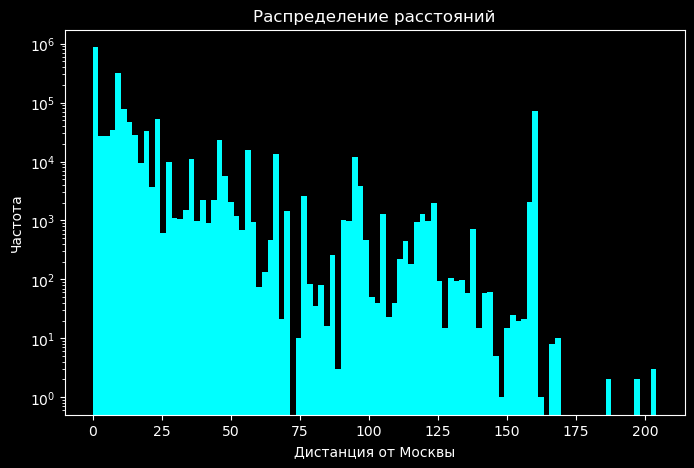

In [129]:
plt.style.use('dark_background')
plt.figure(figsize=(8, 5))
plt.hist(df5.dist_to_msk, bins=100, color='cyan')
plt.xlabel('Дистанция от Москвы')
plt.ylabel('Частота')
plt.yscale('log')
plt.title('Распределение расстояний');

In [130]:
# сохраним словарь координат для повторного использования
joblib.dump(coords, 'data/coords.pkl')

['data/coords.pkl']

## Delete features

In [131]:
df5.columns

Index(['session_id', 'client_id', 'visit_number', 'utm_source', 'utm_medium',
       'utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_category',
       'device_os', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'visit_dt',
       'target_action', 'dayofweek', 'daytime', 'pixels', 'screen_aspect',
       'dist_to_msk'],
      dtype='object')

In [132]:
df_feat = df5.drop(columns=['visit_dt', 'session_id', 'client_id', 'geo_country', 
                            'device_screen_resolution'])

In [133]:
df_feat

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_browser,geo_city,target_action,dayofweek,daytime,pixels,screen_aspect,dist_to_msk
0,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Zlatoust,0,Wednesday,afternoon,5.413635,2.0,22.042931
1,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,Samsung,Moscow,0,Sunday,morning,5.516919,2.2,0.000000
2,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Krasnoyarsk,0,Tuesday,night,5.413635,2.0,55.252251
3,1,kjsLglQLzykiRbcDiGcD,cpc,UvuMsOSDBWQGOIbDbXfV,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,Chrome,Moscow,0,Saturday,night,5.489815,2.0,0.000000
4,2,kjsLglQLzykiRbcDiGcD,cpc,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,Chrome,Moscow,0,Saturday,night,5.489815,2.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,1,BHcvLfOaCWvWTykYqHVe,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,VlqBmecIOXWjCWUmQkLd,desktop,Windows,(not set),Chrome,Moscow,0,Wednesday,morning,6.316725,0.6,0.000000
1860038,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,tVtbIKrPSOvrXLCznVVe,mobile,Android,Apple,Safari,Stavropol,0,Wednesday,morning,5.517407,2.2,11.562113
1860039,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,Safari,Moscow,0,Monday,afternoon,5.398157,1.8,0.000000
1860040,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,Chrome,Chelyabinsk,0,Monday,afternoon,5.524322,2.2,23.821102


## Normalizing

In [134]:
df = df_feat.copy()

In [135]:
num_feat = df[['visit_number', 'dist_to_msk', 'pixels', 'screen_aspect']]
num_feat.head()

,visit_number,dist_to_msk,pixels,screen_aspect
0,1,22.042931,5.413635,2.0
1,1,0.000000,5.516919,2.2
2,1,55.252251,5.413635,2.0
3,1,0.000000,5.489815,2.0
4,2,0.000000,5.489815,2.0


In [136]:
std_scaler = StandardScaler()
std_scaler.fit(num_feat)

StandardScaler()

In [137]:
scaled = std_scaler.transform(num_feat)
scaled

array([[-0.26011958,  0.18253136, -0.71196061,  0.3573443 ],
       [-0.26011958, -0.43944661, -0.37894324,  0.67126267],
       [-0.26011958,  1.11958756, -0.71196061,  0.3573443 ],
       ...,
       [-0.26011958, -0.43944661, -0.76186599,  0.04342592],
       [-0.26011958,  0.23270542, -0.3550721 ,  0.67126267],
       [-0.26011958, -0.43944661,  1.24576022, -1.84008435]])

In [138]:
feat_title = [f"{title}_std" for title in num_feat.columns]

In [139]:
df[feat_title] = scaled
df.drop(columns=num_feat.columns, inplace=True)
df

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_browser,geo_city,target_action,dayofweek,daytime,visit_number_std,dist_to_msk_std,pixels_std,screen_aspect_std
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Zlatoust,0,Wednesday,afternoon,-0.26012,0.182531,-0.711961,0.357344
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,Samsung,Moscow,0,Sunday,morning,-0.26012,-0.439447,-0.378943,0.671263
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Krasnoyarsk,0,Tuesday,night,-0.26012,1.119588,-0.711961,0.357344
3,kjsLglQLzykiRbcDiGcD,cpc,UvuMsOSDBWQGOIbDbXfV,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,Chrome,Moscow,0,Saturday,night,-0.26012,-0.439447,-0.466333,0.357344
4,kjsLglQLzykiRbcDiGcD,cpc,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,Chrome,Moscow,0,Saturday,night,-0.02238,-0.439447,-0.466333,0.357344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,BHcvLfOaCWvWTykYqHVe,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,VlqBmecIOXWjCWUmQkLd,desktop,Windows,(not set),Chrome,Moscow,0,Wednesday,morning,-0.26012,-0.439447,2.199873,-1.840084
1860038,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,tVtbIKrPSOvrXLCznVVe,mobile,Android,Apple,Safari,Stavropol,0,Wednesday,morning,-0.26012,-0.113202,-0.377368,0.671263
1860039,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,Safari,Moscow,0,Monday,afternoon,-0.26012,-0.439447,-0.761866,0.043426
1860040,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,Chrome,Chelyabinsk,0,Monday,afternoon,-0.26012,0.232705,-0.355072,0.671263


In [140]:
df_norm = df.copy()

Для дальнешего применения в моделях нам понадобится 2 типа кодирования категорий:
* Label Encoder
* One Hot Encoder

## Categorial encoding - OHE

In [141]:
df = df_norm.copy()

In [142]:
df.columns

Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_browser', 'geo_city', 'target_action', 'dayofweek', 'daytime',
       'visit_number_std', 'dist_to_msk_std', 'pixels_std',
       'screen_aspect_std'],
      dtype='object')

In [136]:
# заменим в категориальных фичах все '(not set)' и '(none)' значением 'other' 
# for feat in df.columns:
#     df[feat] = df[feat].mask(
#         lambda x: x.isin(('(not set)', '(none)')),
#         'other'
#     )

In [143]:
cat_feat = df[['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_browser', 'geo_city', 'dayofweek', 'daytime',
       ]].astype('category')

In [144]:
print('Общее кол-во категориальных фичей после OHE: ',
      sum([len(cat_feat[col].dtype.categories) for col in cat_feat.columns])
     )

Общее кол-во категориальных фичей после OHE:  4838


In [145]:
def replace_unimportant(
                data: pd.DataFrame, 
                target: str = 'target_action', 
                columns: list = None, 
                trsh: int = 0
            ) -> pd.DataFrame:
    """replace values with 'other', wether values didn't lead to target action"""
    
    columns = data.columns if columns is None else columns 
    for col in columns:
        index_set = {k
                     for k, v in data.groupby(by=col)[target].sum().items()
                     if v > trsh}
        data[col] = data[col].where(data[col].isin(index_set), 'other')
    return data

In [146]:
df2 = replace_unimportant(df, columns=cat_feat.columns, trsh=2)

In [147]:
cat_feat = df2[['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_browser', 'geo_city', 'dayofweek', 'daytime',
       ]].astype('category')

In [148]:
print('Общее кол-во категориальных фичей после OHE: ',
      sum([len(cat_feat[col].dtype.categories) for col in cat_feat.columns])
     )

Общее кол-во категориальных фичей после OHE:  1107


In [149]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(cat_feat)

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [150]:
ohe_cat = ohe.transform(cat_feat)
ohe_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [151]:
ohe.get_feature_names_out()[:10]

array(['utm_source_BHcvLfOaCWvWTykYqHVe',
       'utm_source_BKeImrJuRDZcHiSSTdzm',
       'utm_source_DlnuGwaJBHGNEKdWfOpe',
       'utm_source_DnEUulZAecfGPvdtZBYS',
       'utm_source_FTAuYVNoYYxgvKMpKSLW',
       'utm_source_GmILPdZyuAVJCPsUBHeN',
       'utm_source_GpAkIXsclxDGyILfNlrR',
       'utm_source_HFaOtpcChAlcMuxEAlpu',
       'utm_source_HbolMJUevblAbkHClEQa',
       'utm_source_ISrKoXQCxqqYvAZICvjs'], dtype=object)

In [152]:
# сохраним параметры преобразования в pickle
joblib.dump(ohe, 'data/ohe.pkl')

['data/ohe.pkl']

In [153]:
df_result = pd.concat([df2.drop(columns=cat_feat.columns),
                       pd.DataFrame(index=df2.index,
                                    data=ohe_cat,
                                    columns=ohe.get_feature_names_out()
                                   )
                      ],
                      axis=1
)
df_result.columns

Index(['target_action', 'visit_number_std', 'dist_to_msk_std', 'pixels_std',
       'screen_aspect_std', 'utm_source_BHcvLfOaCWvWTykYqHVe',
       'utm_source_BKeImrJuRDZcHiSSTdzm', 'utm_source_DlnuGwaJBHGNEKdWfOpe',
       'utm_source_DnEUulZAecfGPvdtZBYS', 'utm_source_FTAuYVNoYYxgvKMpKSLW',
       ...
       'dayofweek_Monday', 'dayofweek_Saturday', 'dayofweek_Sunday',
       'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday',
       'daytime_afternoon', 'daytime_evening', 'daytime_morning',
       'daytime_night'],
      dtype='object', length=1112)

In [154]:
df_result

,target_action,visit_number_std,dist_to_msk_std,pixels_std,screen_aspect_std,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_BKeImrJuRDZcHiSSTdzm,utm_source_DlnuGwaJBHGNEKdWfOpe,utm_source_DnEUulZAecfGPvdtZBYS,utm_source_FTAuYVNoYYxgvKMpKSLW,...,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,daytime_afternoon,daytime_evening,daytime_morning,daytime_night
0,0,-0.26012,0.182531,-0.711961,0.357344,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0,-0.26012,-0.439447,-0.378943,0.671263,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,-0.26012,1.119588,-0.711961,0.357344,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0,-0.26012,-0.439447,-0.466333,0.357344,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,-0.02238,-0.439447,-0.466333,0.357344,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,0,-0.26012,-0.439447,2.199873,-1.840084,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1860038,0,-0.26012,-0.113202,-0.377368,0.671263,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1860039,0,-0.26012,-0.439447,-0.761866,0.043426,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1860040,0,-0.26012,0.232705,-0.355072,0.671263,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Export result dataframe

In [155]:
df_result.to_pickle('data/df_result.pkl')

In [151]:
df_result.sample(n=300_000, random_state=42).to_pickle('data/df_small.pkl')